In [89]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

import warnings
warnings.filterwarnings(action='once')

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBRegressor, plot_tree, XGBClassifier

from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold
from scipy import stats

In [3]:
def mode(x):
    return stats.mode(x)[0][0]

In [100]:
def etl_pipeline(df, is_train = False, create_interactions = False, fillna_dict = None,\
                 single_interaction_vars = None, higher_interaction_vars = None, df_grouping_train = None,\
                 target = None):
    assert target != None
    columns = [x.lower() for x in df.columns.tolist()]
    df.columns = columns
    df_etl = df.loc[:,:]
    if is_train == True:
        # apply some filter here
        # df_etl = df_etl.loc[(~df_etl['dob'].isnull()) & (~df_etl['loan_period'].isnull())]
        df_etl = df_etl.loc[(~df_etl['dob'].isnull())]
        
    # create new variables
    df_etl['dob_year'] = df_etl['dob'].apply(lambda x: datetime.strptime(x, '%d/%m/%y').year if int(x[-2:]) > 16 else 2000 + int(x[-2:]))
    df_etl['dob_month'] = df_etl['dob'].apply(lambda x: datetime.strptime(x, '%d/%m/%y').month)
    df_etl['creation_month'] = df_etl['lead_creation_date'].apply(lambda x: datetime.strptime(x, '%d/%m/%y').month)
    df_etl['creation_day'] = df_etl['lead_creation_date'].apply(lambda x: datetime.strptime(x, '%d/%m/%y').day)
    df_etl['creation_is_weekday'] = df_etl['lead_creation_date'].apply(lambda x: 1 if datetime.strptime(x, '%d/%m/%y').weekday() >= 5 else 0)
    df_etl['age'] = df_etl['dob_year'].apply(lambda x: 2016 - x)
    df_etl['int_rate_missing'] = df_etl['interest_rate'].apply(lambda x: 1 if pd.isnull(x) else 0)
    df_etl['bank_missing'] = df_etl['primary_bank_type'].apply(lambda x: 1 if pd.isnull(x) else 0)
    df_etl['employer_missing'] = df_etl['employer_code'].apply(lambda x: 1 if pd.isnull(x) else 0)
    df_etl['total_income_minus_total_loan'] = df_etl.apply(lambda x: x['loan_period'] * 12 * x['monthly_income'] * 0.2 - \
                                                           x['loan_amount'] * (1 + np.power(1.1, x['loan_period'])), axis = 1)
    df_etl['monthly_income'] = df_etl['monthly_income'].apply(lambda x: 15000 if x > 15000 else x)
    df_etl['is_income_zero'] = df_etl['monthly_income'].apply(lambda x: 1 if x == 0 else 0)
    df_etl['existing_emi'] = df_etl['existing_emi'].apply(lambda x: 30000 if x >= 30000 else x)
    df_etl['existing_emi'] = df_etl['existing_emi'].apply(lambda x: 2 if x <= 2 else x)
    df_etl['existing_loan'] = df_etl['existing_emi'].apply(lambda x: 0 if pd.isnull(x) or x == 0 else 1)

    # encode basic variables
    employer_category1_dict = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
    df_etl['employer_category1'] = df_etl['employer_category1'].apply(lambda x: employer_category1_dict[x] if x in employer_category1_dict else x)
    df_etl['city_category'] = df_etl['city_category'].apply(lambda x: employer_category1_dict[x] if x in employer_category1_dict else x)
    df_etl['source_category'] = df_etl['source_category'].apply(lambda x: employer_category1_dict[x] if x in employer_category1_dict else x)
    city_list = ['C10001','C10002','C10003','C10004','C10005','C10006','C10007','C10008','C10009','C10010','C10011','C10012','C10013','C10014','C10015','C10016']
    df_etl['city_code_1d'] = df_etl['city_code'].apply(lambda x: int(x[-1:]) if x in city_list else len(city_list) + 1)
    df_etl['city_code_2d'] = df_etl['city_code'].apply(lambda x: int(x[-2:]) if x in city_list else len(city_list) + 1)
    df_etl['city_code_3d'] = df_etl['city_code'].apply(lambda x: int(x[-3:]) if x in city_list else len(city_list) + 1)
    df_etl['contacted'] = df_etl['contacted'].apply(lambda x: 1 if x == 'Y' else 0)
    df_etl['gender'] = df_etl['gender'].apply(lambda x: 1 if x == 'Male' else 0)
    source_code_list = ['S134','S137','S127','S143','S159','S133','S122']
    df_etl['source'] = df_etl['source'].apply(lambda x: int(x[-3:]) if x in source_code_list else 1)

    # fill missing values
    if fillna_dict is not None:
        df_etl.fillna(fillna_dict, inplace = True)
    
    if create_interactions == True and is_train == True:
        if single_interaction_vars is not None:
            df_grouping = {}
            for var_to_group in single_interaction_vars:
                print (var_to_group)
                df_grouping[var_to_group] = df_etl.groupby([var_to_group])\
                                                  .agg({target:[np.mean, 'count']})
                new_col_names =  [df_grouping[var_to_group].index.name] + ['_'.join([df_grouping[var_to_group].index.name] + list(x)) \
                                  for x in (df_grouping[var_to_group].columns.ravel())]
                # print (new_col_names)
                df_grouping[var_to_group].reset_index(inplace = True)
                df_grouping[var_to_group].columns = new_col_names
                for col in df_grouping[var_to_group].columns:
                    if '_count' in col:
                        df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

                df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = var_to_group, how = 'left')

        if higher_interaction_vars is not None:
            for var_to_group in higher_interaction_vars:
                print (var_to_group)
                df_grouping[var_to_group] = df_etl.groupby(list(var_to_group))\
                                              .agg({target:[np.mean, 'count']})
                new_col_names =  list(var_to_group) + ['_'.join(['_'.join(var_to_group)] + list(x)) \
                                  for x in (df_grouping[var_to_group].columns.ravel())]
                df_grouping[var_to_group].reset_index(inplace = True)
                df_grouping[var_to_group].columns = new_col_names
                for col in df_grouping[var_to_group].columns:
                    if '_count' in col[-6:]:
                        df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

                df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = list(var_to_group), how = 'left')
            
    if is_train == False and create_interactions == True:
        assert df_grouping_train is not None
        for var_to_group in df_grouping_train.keys():
            df_etl = pd.merge(left = df_etl, right = df_grouping_train[var_to_group], on = var_to_group, how = 'left')
        
    if is_train == True:
        if (len(df_grouping) > 0):
            return (df_etl, df_grouping)
    return (df_etl)
    

In [114]:
df = pd.read_csv('../inputs/train.csv')
fillna_dict = {'employer_category1':-1, 'employer_category2':-1,\
               'customer_existing_primary_bank_code':-1, 'primary_bank_type':-1,\
               'existing_emi':0, 'loan_period':-1, 'loan_amount':-1}
single_interaction_vars = ['city_category','employer_category1','employer_category2',\
                           'customer_existing_primary_bank_code','primary_bank_type','source',\
                           'source_category','var1']
higher_interaction_vars = [('employer_category1','employer_category2'), ('source', 'city_category'),\
                           ('var1', 'source'), ('existing_loan', 'var1')]

In [115]:
df, df_grouping_train = etl_pipeline(df, is_train = True, create_interactions = True, fillna_dict = fillna_dict,\
                                     single_interaction_vars = single_interaction_vars, \
                                     higher_interaction_vars = higher_interaction_vars, \
                                     target = 'approved')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


city_category
employer_category1
employer_category2
customer_existing_primary_bank_code
primary_bank_type
source
source_category
var1
('employer_category1', 'employer_category2')
('source', 'city_category')
('var1', 'source')
('existing_loan', 'var1')


In [116]:
print (df.dtypes)

id                                                       object
gender                                                    int64
dob                                                      object
lead_creation_date                                       object
city_code                                                object
city_category                                           float64
employer_code                                            object
employer_category1                                      float64
employer_category2                                      float64
monthly_income                                          float64
customer_existing_primary_bank_code                      object
primary_bank_type                                        object
contacted                                                 int64
source                                                    int64
source_category                                           int64
existing_emi                            

In [117]:
input_cols_xgb_encode = [] 
input_cols_xgb_numeric = df.dtypes[(df.dtypes == np.int64) | (df.dtypes == np.float64)].index.tolist()
# print (input_cols_xgb_numeric)
input_cols_xgb_numeric.remove('approved')
target_cols_xgb = ['approved']

In [118]:
# remove low feature importance columns
low_importance_cols = ['var1_approved_mean','source_category_approved_count','var1_approved_count',\
                       'source_approved_mean','existing_loan_var1_approved_count','gender_source_approved_mean',\
                       'source_approved_count','city_code_3d','primary_bank_type_approved_count','employer_missing',\
                       'employer_category1','employer_category2','contacted','var1','creation_is_weekday',\
                       'bank_missing','is_income_zero','primary_bank_type_approved_mean','existing_loan',\
                       'employer_category1_approved_mean','employer_category1_approved_count',\
                       'employer_category2_approved_mean','employer_category2_approved_count',\
                       'customer_existing_primary_bank_code_approved_count','gender_source_approved_count']
for col in list(low_importance_cols):
    if col in input_cols_xgb_encode:
        input_cols_xgb_encode.remove(col)
    if col in input_cols_xgb_numeric:
        input_cols_xgb_numeric.remove(col)
        
print (input_cols_xgb_numeric)

['gender', 'city_category', 'monthly_income', 'source', 'source_category', 'existing_emi', 'loan_amount', 'loan_period', 'interest_rate', 'emi', 'dob_year', 'dob_month', 'creation_month', 'creation_day', 'age', 'int_rate_missing', 'total_income_minus_total_loan', 'city_code_1d', 'city_code_2d', 'city_category_approved_mean', 'city_category_approved_count', 'customer_existing_primary_bank_code_approved_mean', 'source_category_approved_mean', 'employer_category1_employer_category2_approved_mean', 'employer_category1_employer_category2_approved_count', 'source_city_category_approved_mean', 'source_city_category_approved_count', 'var1_source_approved_mean', 'var1_source_approved_count', 'existing_loan_var1_approved_mean']


In [119]:
X_xgb = df[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()
label_enc = [LabelEncoder() for i in range(len(input_cols_xgb_encode))]

for i in range(len(label_enc)):
    print (input_cols_xgb_encode[i])
    label_enc[i].fit(X_xgb[:, i])
    X_xgb[:, i] = label_enc[i].transform(X_xgb[:, i])

y_xgb = df[target_cols_xgb].as_matrix().reshape(-1,)

In [120]:
print (X_xgb.shape, y_xgb.shape, y_xgb.sum())

(69698, 30) (69698,) 1020


In [34]:
69698/1020

68.3313725490196

In [35]:
y_xgb_weights = (y_xgb * 5) + 1

In [36]:
# xgboost parameter tuning

In [37]:
# get the optimum no of trees for learning rate of 0.1
parameters = {'n_estimators' : [10, 50, 100, 150, 200, 250, 500]}
xgb_clf = XGBClassifier(random_state=42)
clf = GridSearchCV(xgb_clf, parameters, cv = 3, scoring = 'roc_auc')
clf.fit(X_xgb, y_xgb, sample_weight = y_xgb_weights)
print (clf.best_params_)

{'n_estimators': 100}


In [38]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.551299,0.017114,0.820522,0.846071,10,{'n_estimators': 10},7,0.816648,0.849526,0.829144,0.842275,0.815774,0.846412,0.012241,0.000738,0.006107,0.002970
1,2.802908,0.036263,0.840331,0.870615,50,{'n_estimators': 50},5,0.834679,0.873302,0.847931,0.867688,0.838384,0.870855,0.233732,0.003073,0.005583,0.002298
2,4.743502,0.061904,0.846876,0.896073,100,{'n_estimators': 100},1,0.842407,0.897519,0.853354,0.894997,0.844868,0.895703,0.075045,0.000974,0.004690,0.001062
3,8.385861,0.108790,0.846692,0.908575,150,{'n_estimators': 150},2,0.843624,0.909984,0.852929,0.907432,0.843524,0.908307,0.459658,0.018091,0.004410,0.001059
4,9.601348,0.124715,0.845726,0.919571,200,{'n_estimators': 200},3,0.845885,0.919896,0.851751,0.917786,0.839542,0.921030,0.600064,0.003855,0.004986,0.001344
5,13.543044,0.203879,0.843032,0.928491,250,{'n_estimators': 250},4,0.845270,0.928123,0.850548,0.927625,0.833276,0.929725,0.765239,0.032682,0.007227,0.000896
6,28.131581,0.408562,0.832361,0.958520,500,{'n_estimators': 500},6,0.840981,0.957387,0.843067,0.956980,0.813036,0.961194,1.176016,0.048941,0.013692,0.001898


In [39]:
# now tune the max_depth and min_child_weight
parameters = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb_clf = XGBClassifier(random_state=42, learning_rate = 0.1, n_estimators = 100)
clf = GridSearchCV(xgb_clf, parameters, cv = 3, scoring = 'roc_auc')
clf.fit(X_xgb, y_xgb, sample_weight = y_xgb_weights)
print (clf.best_params_)

{'max_depth': 3, 'min_child_weight': 3}


In [40]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.683357,0.061673,0.846876,0.896073,3,1,"{'max_depth': 3, 'min_child_weight': 1}",2,0.842407,0.897519,0.853354,0.894997,0.844868,0.895703,0.016451,0.005108,0.004690,0.001062
1,5.735681,0.076372,0.846880,0.894429,3,3,"{'max_depth': 3, 'min_child_weight': 3}",1,0.843734,0.895725,0.852638,0.892244,0.844269,0.895319,0.558346,0.006553,0.004077,0.001554
2,6.025516,0.065498,0.846363,0.893526,3,5,"{'max_depth': 3, 'min_child_weight': 5}",3,0.842298,0.894155,0.853878,0.892626,0.842912,0.893797,0.864987,0.005483,0.005320,0.000653
3,9.109265,0.101596,0.841749,0.944600,5,1,"{'max_depth': 5, 'min_child_weight': 1}",4,0.843319,0.946075,0.850636,0.943738,0.831291,0.943987,0.632697,0.006755,0.007975,0.001048
4,8.477571,0.098093,0.839960,0.940482,5,3,"{'max_depth': 5, 'min_child_weight': 3}",6,0.841659,0.945410,0.849218,0.938121,0.829002,0.937915,0.103055,0.007212,0.008340,0.003486
5,8.431064,0.094582,0.840446,0.939118,5,5,"{'max_depth': 5, 'min_child_weight': 5}",5,0.842338,0.940376,0.852588,0.939364,0.826413,0.937614,0.077789,0.004568,0.010769,0.001141
6,14.558174,0.168792,0.833441,0.984273,7,1,"{'max_depth': 7, 'min_child_weight': 1}",7,0.832694,0.984644,0.845414,0.985976,0.822214,0.982199,0.564148,0.019523,0.009486,0.001564
7,15.227779,0.157085,0.832152,0.981811,7,3,"{'max_depth': 7, 'min_child_weight': 3}",8,0.832689,0.982809,0.846085,0.980432,0.817680,0.982190,0.298665,0.021490,0.011602,0.001007
8,13.502229,0.163307,0.831078,0.980939,7,5,"{'max_depth': 7, 'min_child_weight': 5}",9,0.837586,0.982007,0.842937,0.981117,0.812710,0.979693,0.252215,0.038349,0.013170,0.000953
9,17.773343,0.203135,0.823360,0.998412,9,1,"{'max_depth': 9, 'min_child_weight': 1}",12,0.818793,0.998343,0.841265,0.998288,0.810023,0.998606,0.310499,0.037933,0.013157,0.000139


In [41]:
# check the values in the neighbourhood of the above values
parameters = {
 'max_depth':[2, 3, 4],
 'min_child_weight':[2, 3, 4]
}
xgb_clf = XGBClassifier(random_state=42, learning_rate = 0.1, n_estimators = 100)
clf = GridSearchCV(xgb_clf, parameters, cv = 3, scoring = 'roc_auc')
clf.fit(X_xgb, y_xgb, sample_weight = y_xgb_weights)
print (clf.best_params_)

{'max_depth': 3, 'min_child_weight': 2}


In [42]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,3.886613,0.052720,0.845066,0.872723,2,2,"{'max_depth': 2, 'min_child_weight': 2}",5,0.840180,0.874619,0.852901,0.869942,0.842118,0.873608,0.229478,0.013361,0.005596,0.002010
1,3.658986,0.044067,0.845013,0.872697,2,3,"{'max_depth': 2, 'min_child_weight': 3}",6,0.839837,0.874284,0.852784,0.870375,0.842417,0.873431,0.468447,0.002989,0.005595,0.001678
2,3.095652,0.042368,0.845314,0.872572,2,4,"{'max_depth': 2, 'min_child_weight': 4}",4,0.840717,0.874292,0.852880,0.870553,0.842343,0.872871,0.026113,0.003750,0.005392,0.001541
3,5.363074,0.063315,0.847202,0.894478,3,2,"{'max_depth': 3, 'min_child_weight': 2}",1,0.843505,0.895288,0.853488,0.893577,0.844614,0.894569,0.293776,0.001536,0.004468,0.000702
4,4.938422,0.065492,0.846880,0.894429,3,3,"{'max_depth': 3, 'min_child_weight': 3}",3,0.843734,0.895725,0.852638,0.892244,0.844269,0.895319,0.121759,0.005974,0.004077,0.001554
5,5.846829,0.080094,0.847006,0.893615,3,4,"{'max_depth': 3, 'min_child_weight': 4}",2,0.842420,0.894564,0.853269,0.892734,0.845330,0.893548,0.366887,0.013419,0.004585,0.000748
6,6.782998,0.080724,0.844330,0.917170,4,2,"{'max_depth': 4, 'min_child_weight': 2}",8,0.841899,0.918531,0.851205,0.917361,0.839885,0.915617,0.283333,0.006872,0.004931,0.001197
7,7.017740,0.078542,0.844727,0.915308,4,3,"{'max_depth': 4, 'min_child_weight': 3}",7,0.843681,0.917480,0.850119,0.915578,0.840381,0.912865,0.331636,0.005342,0.004044,0.001894
8,6.475588,0.078548,0.843923,0.916254,4,4,"{'max_depth': 4, 'min_child_weight': 4}",9,0.842737,0.917129,0.850051,0.916188,0.838981,0.915446,0.071549,0.003300,0.004597,0.000688


In [43]:
# tune the value of gamma
parameters = {
 'gamma':[x/10.0 for x in range(6)]
}
xgb_clf = XGBClassifier(random_state=42, learning_rate = 0.1, n_estimators = 100, \
                       max_depth = 3, min_child_weight = 2)
clf = GridSearchCV(xgb_clf, parameters, cv = 3, scoring = 'roc_auc')
clf.fit(X_xgb, y_xgb, sample_weight = y_xgb_weights)
print (clf.best_params_)

{'gamma': 0.0}


In [44]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.919874,0.062498,0.847202,0.894478,0,{'gamma': 0.0},1,0.843505,0.895288,0.853488,0.893577,0.844614,0.894569,0.048280,0.000257,0.004468,0.000702
1,4.858049,0.062008,0.846955,0.894365,0.1,{'gamma': 0.1},2,0.843505,0.895288,0.853488,0.893577,0.843874,0.894230,0.067564,0.003108,0.004622,0.000705
2,4.869168,0.062514,0.846865,0.894228,0.2,{'gamma': 0.2},3,0.843505,0.895288,0.853215,0.893165,0.843874,0.894230,0.057493,0.002096,0.004493,0.000867
3,4.844814,0.063505,0.846847,0.894227,0.3,{'gamma': 0.3},4,0.843505,0.895288,0.853215,0.893165,0.843821,0.894229,0.059762,0.002602,0.004505,0.000867
4,4.864955,0.062486,0.846601,0.894078,0.4,{'gamma': 0.4},5,0.843505,0.895288,0.852488,0.892719,0.843811,0.894226,0.056869,0.003828,0.004164,0.001054
5,4.996928,0.067174,0.846601,0.894077,0.5,{'gamma': 0.5},6,0.843505,0.895288,0.852488,0.892719,0.843811,0.894225,0.154231,0.006451,0.004165,0.001054


In [45]:
# tune the value of subsample and colsample_bytree
parameters = {
 'subsample':[x/10.0 for x in range(6,11)],
 'colsample_bytree':[x/10.0 for x in range(6,11)]
}
xgb_clf = XGBClassifier(random_state=42, learning_rate = 0.1, n_estimators = 100, \
                       max_depth = 3, min_child_weight = 2, gamma = 0.0)
clf = GridSearchCV(xgb_clf, parameters, cv = 3, scoring = 'roc_auc')
clf.fit(X_xgb, y_xgb, sample_weight = y_xgb_weights)
print (clf.best_params_)

{'colsample_bytree': 0.8, 'subsample': 0.9}


In [46]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.825746,0.067023,0.848061,0.894346,0.6,0.6,"{'colsample_bytree': 0.6, 'subsample': 0.6}",2,0.841772,0.894801,0.853959,0.891685,0.848453,0.896553,0.097225,0.003013,0.004983,0.002013
1,4.448977,0.066000,0.847897,0.894768,0.6,0.7,"{'colsample_bytree': 0.6, 'subsample': 0.7}",7,0.842278,0.895488,0.854613,0.893817,0.846801,0.895000,0.039134,0.002454,0.005095,0.000702
2,4.046857,0.066834,0.846793,0.894647,0.6,0.8,"{'colsample_bytree': 0.6, 'subsample': 0.8}",21,0.841254,0.894877,0.853579,0.893274,0.845546,0.895789,0.020889,0.003405,0.005108,0.001040
3,3.713593,0.065152,0.847361,0.894125,0.6,0.9,"{'colsample_bytree': 0.6, 'subsample': 0.9}",14,0.843503,0.894876,0.853489,0.892697,0.845091,0.894801,0.016351,0.002963,0.004382,0.001010
4,3.293632,0.065372,0.846386,0.891690,0.6,1,"{'colsample_bytree': 0.6, 'subsample': 1.0}",24,0.840527,0.893262,0.852804,0.889552,0.845827,0.892256,0.028407,0.002256,0.005028,0.001567
5,5.373460,0.066010,0.846858,0.895958,0.7,0.6,"{'colsample_bytree': 0.7, 'subsample': 0.6}",20,0.839987,0.897660,0.851543,0.894508,0.849044,0.895706,0.075659,0.001959,0.004964,0.001299
6,4.998725,0.066569,0.847721,0.895641,0.7,0.7,"{'colsample_bytree': 0.7, 'subsample': 0.7}",8,0.842086,0.896366,0.855280,0.894762,0.845796,0.895795,0.027595,0.005915,0.005556,0.000664
7,4.539078,0.065358,0.847089,0.895931,0.7,0.8,"{'colsample_bytree': 0.7, 'subsample': 0.8}",17,0.842104,0.895985,0.852796,0.895662,0.846368,0.896146,0.044728,0.002785,0.004395,0.000201
8,4.120628,0.066866,0.846600,0.895999,0.7,0.9,"{'colsample_bytree': 0.7, 'subsample': 0.9}",22,0.840867,0.896103,0.853483,0.894341,0.845449,0.897553,0.048680,0.005582,0.005215,0.001313
9,3.681547,0.066019,0.845215,0.892254,0.7,1,"{'colsample_bytree': 0.7, 'subsample': 1.0}",25,0.840352,0.893170,0.852151,0.891084,0.843141,0.892509,0.022272,0.002677,0.005035,0.000870


In [47]:
# tune the value of subsample and colsample_bytree with more tight intervals
parameters = {
 'colsample_bytree':[0.75, 0.8, 0.85],
 'subsample':[0.85, 0.9, 0.95]
 
}
xgb_clf = XGBClassifier(random_state=42, learning_rate = 0.1, n_estimators = 100, \
                       max_depth = 3, min_child_weight = 2, gamma = 0.0)
clf = GridSearchCV(xgb_clf, parameters, cv = 3, scoring = 'roc_auc')
clf.fit(X_xgb, y_xgb, sample_weight = y_xgb_weights)
print (clf.best_params_)

{'colsample_bytree': 0.75, 'subsample': 0.95}


In [48]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.041171,0.068625,0.848275,0.896373,0.75,0.85,"{'colsample_bytree': 0.75, 'subsample': 0.85}",3,0.846528,0.897376,0.852333,0.894279,0.845964,0.897464,0.333981,0.007218,0.002878,0.001481
1,4.740530,0.063625,0.847723,0.895369,0.75,0.9,"{'colsample_bytree': 0.75, 'subsample': 0.9}",8,0.842886,0.896212,0.854466,0.892240,0.845817,0.897655,0.165601,0.001062,0.004916,0.002290
2,4.337103,0.068514,0.849114,0.895820,0.75,0.95,"{'colsample_bytree': 0.75, 'subsample': 0.95}",1,0.845123,0.896239,0.855892,0.894602,0.846327,0.896621,0.025196,0.008345,0.004818,0.000876
3,5.057485,0.063974,0.847954,0.896801,0.8,0.85,"{'colsample_bytree': 0.8, 'subsample': 0.85}",6,0.845471,0.897324,0.854822,0.895423,0.843569,0.897657,0.115234,0.003874,0.004918,0.000984
4,4.941320,0.070189,0.848195,0.896621,0.8,0.9,"{'colsample_bytree': 0.8, 'subsample': 0.9}",4,0.843463,0.896013,0.854651,0.894816,0.846473,0.899034,0.046926,0.007230,0.004727,0.001775
5,4.576023,0.071368,0.847959,0.895480,0.8,0.95,"{'colsample_bytree': 0.8, 'subsample': 0.95}",5,0.842108,0.895264,0.855307,0.894352,0.846461,0.896825,0.039447,0.005543,0.005491,0.001021
6,5.280896,0.076037,0.848672,0.896707,0.85,0.85,"{'colsample_bytree': 0.85, 'subsample': 0.85}",2,0.846747,0.896583,0.855213,0.896409,0.844057,0.897129,0.033112,0.009847,0.004753,0.000307
7,4.990327,0.071493,0.847790,0.897480,0.85,0.9,"{'colsample_bytree': 0.85, 'subsample': 0.9}",7,0.842090,0.898145,0.854396,0.895058,0.846884,0.899236,0.096321,0.009827,0.005065,0.001770
8,4.807589,0.066199,0.847561,0.897143,0.85,0.95,"{'colsample_bytree': 0.85, 'subsample': 0.95}",9,0.843367,0.896711,0.854936,0.894848,0.844379,0.899871,0.069392,0.005743,0.005231,0.002073


In [49]:
# tune regularization value alpha
parameters = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
xgb_clf = XGBClassifier(random_state=42, learning_rate = 0.1, n_estimators = 100, \
                       max_depth = 3, min_child_weight = 2, gamma = 0, \
                       colsample_bytree = 0.75, subsample = 0.95)
clf = GridSearchCV(xgb_clf, parameters, cv = 3, scoring = 'roc_auc')
clf.fit(X_xgb, y_xgb, sample_weight = y_xgb_weights)
print (clf.best_params_)

{'reg_alpha': 0}


In [50]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_reg_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.190150,0.065454,0.849114,0.895820,0,{'reg_alpha': 0},1,0.845123,0.896239,0.855892,0.894602,0.846327,0.896621,0.205655,0.000999,0.004818,0.000876
1,4.401047,0.067524,0.849114,0.895820,1e-05,{'reg_alpha': 1e-05},2,0.845123,0.896239,0.855892,0.894602,0.846327,0.896621,0.097352,0.000487,0.004818,0.000876
2,4.464923,0.067666,0.849113,0.895814,0.01,{'reg_alpha': 0.01},3,0.845122,0.896232,0.855891,0.894595,0.846327,0.896614,0.051477,0.001785,0.004817,0.000876
3,4.436798,0.066009,0.848788,0.894873,0.1,{'reg_alpha': 0.1},4,0.843936,0.895818,0.856480,0.892512,0.845947,0.896288,0.164651,0.000852,0.005501,0.001680
4,4.657522,0.068513,0.847714,0.895096,1,{'reg_alpha': 1},5,0.844763,0.895649,0.855296,0.893694,0.843082,0.895943,0.072352,0.006751,0.005405,0.000998
5,4.612772,0.073181,0.841263,0.869422,100,{'reg_alpha': 100},6,0.836418,0.870681,0.844938,0.867285,0.842435,0.870301,0.022187,0.005230,0.003576,0.001519


In [51]:
# tune the learning rate
parameters = {
 'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.3]
}
xgb_clf = XGBClassifier(random_state=42, n_estimators = 500, \
                       max_depth = 3, min_child_weight = 2, gamma = 0, \
                       colsample_bytree = 0.75, subsample = 0.95, reg_alpha = 0.0)
clf = GridSearchCV(xgb_clf, parameters, cv = 3, scoring = 'roc_auc')
clf.fit(X_xgb, y_xgb, sample_weight = y_xgb_weights)
print (clf.best_params_)

{'learning_rate': 0.05}


In [52]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,21.538421,0.272227,0.827130,0.848274,0.001,{'learning_rate': 0.001},4,0.824988,0.851574,0.832205,0.844811,0.824198,0.848437,1.107057,0.016558,0.003603,0.002763
1,22.224323,0.338772,0.842065,0.872521,0.01,{'learning_rate': 0.01},2,0.834720,0.873912,0.849614,0.869228,0.841862,0.874421,0.259676,0.005083,0.006082,0.002337
2,21.746639,0.409255,0.844863,0.932205,0.05,{'learning_rate': 0.05},1,0.846763,0.929838,0.850349,0.932310,0.837477,0.934468,0.352248,0.013907,0.005424,0.001892
3,22.053222,0.392543,0.833596,0.964267,0.1,{'learning_rate': 0.1},3,0.841072,0.961999,0.842277,0.963934,0.817439,0.966866,0.310051,0.021658,0.011435,0.002001
4,22.083273,0.422803,0.802676,0.995211,0.3,{'learning_rate': 0.3},5,0.815380,0.994516,0.816162,0.995769,0.776484,0.995349,0.073247,0.011212,0.018522,0.000521


In [121]:
# train the final classifier
model_list = []
kf = KFold(n_splits = 4, shuffle = True)
kf_index = 0
for train_indices, test_indices in kf.split(X_xgb):
    X_train, X_test = X_xgb[train_indices], X_xgb[test_indices]
    y_train, y_test = y_xgb[train_indices], y_xgb[test_indices]
    xgb_clf = XGBClassifier(random_state=42, learning_rate = 0.05, n_estimators = 500, \
                               max_depth = 3, min_child_weight = 2, gamma = 0.0, \
                               colsample_bytree = 0.75, subsample = 0.95, reg_alpha = 0.0)
    xgb_clf.fit(X_xgb, y_xgb, sample_weight = y_xgb_weights)
    model_list.append(xgb_clf)
    kf_index += 1
    
    print(str(kf_index) + ',' + ' Train : ' + str(round(roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:,1]), 5)) + \
          ' , Test : ' + str(round(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1]), 5)))

1, Train : 0.92132 , Test : 0.91501
2, Train : 0.92096 , Test : 0.91587
3, Train : 0.91775 , Test : 0.9262
4, Train : 0.91865 , Test : 0.92246


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


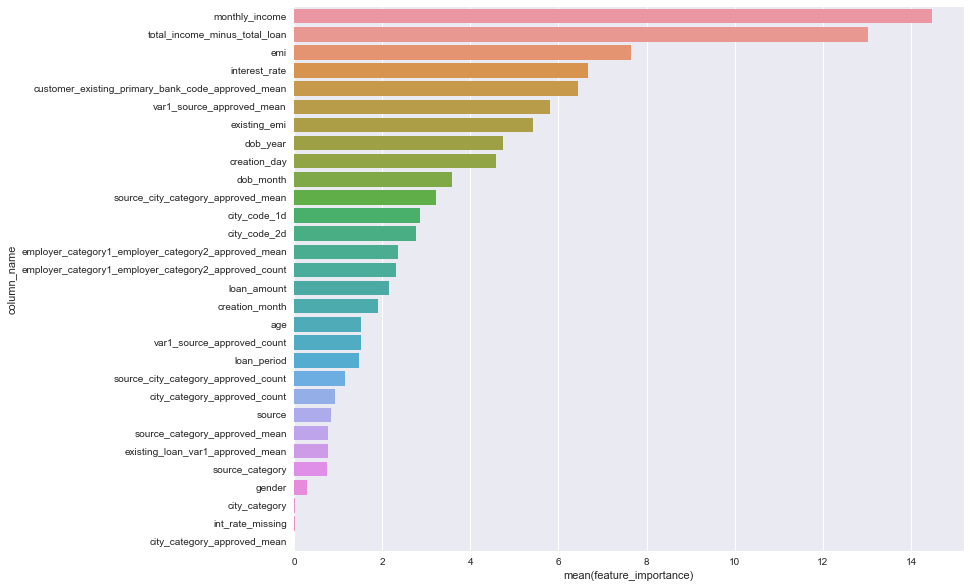

In [122]:
# plot the feature importances
df_feature_importance = pd.DataFrame(list(zip((input_cols_xgb_encode + input_cols_xgb_numeric), \
                                              xgb_clf.feature_importances_)),\
                                     columns = ['column_name', 'feature_importance'])
df_feature_importance = df_feature_importance.sort_values(by = 'feature_importance', ascending = False).reset_index()
df_feature_importance['feature_importance'] *= 100
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(12 , 10))
sns.barplot(x = 'feature_importance', y = 'column_name', data = df_feature_importance)

In [200]:
df_feature_importance

,index,column_name,feature_importance
0,3,monthly_income,15.703604
1,18,total_income_minus_total_loan,13.902107
2,9,emi,9.211421
3,8,interest_rate,6.764106
4,11,dob_year,6.764106
5,5,existing_emi,5.370496
6,27,customer_existing_primary_bank_code_approved_mean,4.996601
7,1,city_code,4.792658
8,12,dob_month,4.112848
9,6,loan_amount,4.044867


In [74]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

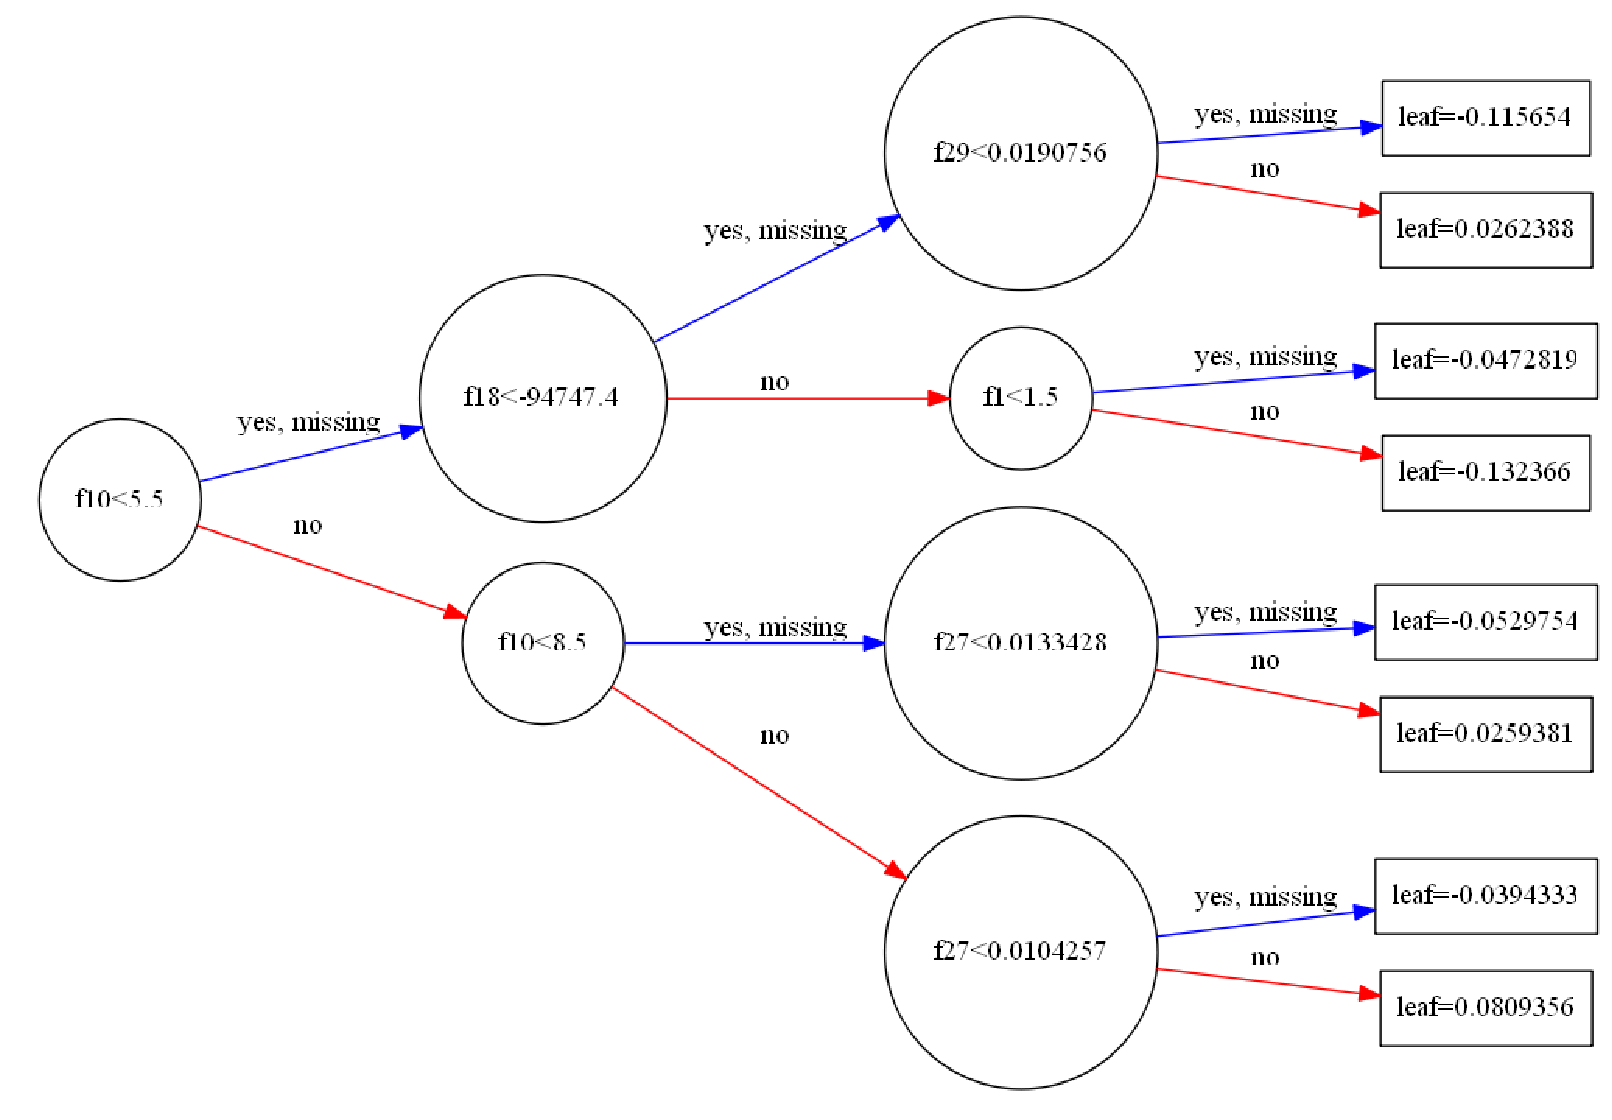

In [120]:
# plot the tree
fig, axs = plt.subplots(nrows = 1, figsize = (40, 20))
plot_tree(xgb_clf, num_trees = 1, rankdir = 'LR', ax = axs)

In [123]:
# make predictions on the test set
df_test = pd.read_csv('../inputs/test.csv')

In [124]:
# test_filter = (df_test['DOB'].isnull()) | (df_test['Loan_Period'].isnull())
test_filter = (df_test['DOB'].isnull())
df_test_1 = df_test.loc[test_filter, :]
df_test_1['Approved'] = 0
df_test = df_test.loc[~test_filter, :]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [125]:
df_test = etl_pipeline(df_test, is_train=False, create_interactions=True, fillna_dict=fillna_dict,\
                      df_grouping_train=df_grouping_train, target = 'approved')

In [126]:
# make predictions on the test set with the optimum parameters
X_xgb_test = df_test[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()

for i in range(len(label_enc)):
    X_xgb_test[:, i] = label_enc[i].transform(X_xgb_test[:, i])

df_submit = pd.DataFrame(df_test['id'])
df_submit.rename(columns = {'id':'ID'}, inplace = True)
df_submit['Approved'] = np.mean([clf.predict_proba(X_xgb_test)[:,1] for clf in model_list], axis = 0)
df_submit = pd.concat([df_submit, df_test_1[['ID', 'Approved']]])

df_submit.to_csv('../submissions/submit_20180121_0203_xgb.csv', index=False)


In [127]:
# take ensembles
for folder_name, subfolder_names, submit_files  in os.walk('../submissions/'):
    pass
df_temp_list = []
for file in submit_files:
    if 'all_prev' not in file:
        df_temp = pd.read_csv(folder_name + file)
        df_temp_list.append(df_temp.loc[:,:])
df_temp = pd.concat(df_temp_list).groupby(['ID']).mean().reset_index()
df_temp.to_csv('../submissions/submit_20180121_0215_all_prev.csv', index = False)